In [2]:
#] add DifferentialEqTsit5

# White Dwarfs

In [5]:
using OrdinaryDiffEqTsit5
using PyPlot
using DataFrames
using CSV

In [6]:
# url = "http://vizier.u-strasbg.fr/viz-bin/asu-tsv?-source=J/A+A/420/507/tablea1&-out=Mass&-out=Rad" offline 2025-10-22
url = "https://cdsarc.u-strasbg.fr/viz-bin/asu-tsv?-source=J/A+A/420/507/tablea1&-out=Mass&-out=Rad"
catalog = download(url)

"/tmp/jl_m3oByt4Ziv"

In [20]:

df = CSV.read(catalog, DataFrame, comment="#", skipto=4, 
              types=[Float64, Float64], delim='\t', ignorerepeated=true, 
              silencewarnings=true);

In [21]:

dropmissing!(df);

In [16]:
"""
    white_dwarf_eqs!(dudr, u, p, r)

The right hand side of the system of 2 dimensionless differential 
equations describing the radial distribution of the density, rho(r),
and mass, m(r), inside a white dwarf star

     m' =  rho r^2
   rho' = -m rho /(gamma(\rho) r^2)

where gamma(rho) = rho^(2/3)/(3 sqrt(1 + rho^(2/3)))
"""
function white_dwarf_eqs!(dudr, u, p, r)
    m = u[1]
    rho = u[2]
    rho_c = p
    if rho >= 0.0
        w = rho^(2/3)
        gamma = w/(3 * sqrt(1 + w))
        dudr[1] = rho * r * r
        if (r > 1.e-6)
            dudr[2] = -m * rho/(gamma * r * r)
        else
            dudr[2] = -rho_c/3 * r * rho/gamma
        end
    else
        dudr[1] = 0.0
        dudr[2] = 0.0
    end
end

white_dwarf_eqs!

In [17]:
rho_c1 = 0.08      #  min density in the star center
rho_c2 = 100000.0  #  max density in the star center
np = 100

rhos = exp.(range(log(rho_c1), log(rho_c2), np));

In [18]:

radi = zeros(np)
mass = zeros(np);

In [22]:

rspan = (0.0, 10.0)

(0.0, 10.0)

In [23]:

for i = 1:np 

    rho_c = rhos[i]
    
    # New initial conditions
    u0 = [0.0, rho_c]

    # Set up the new problem
    prob = ODEProblem(white_dwarf_eqs!, u0, rspan, rho_c)

    # Set up the callback
    condition(u, t, integrator) = u[2]  # stop integration when rho = 0.
    affect!(integrator) = terminate!(integrator)
    cb = ContinuousCallback(condition, affect!)

    # Integrate the ODEs
    sol = solve(prob, Tsit5(), callback=cb)

    # Store the relevant part: the radius and the mass of the white dwarf.
    radi[i] = sol.t[end]
    mass[i] = sol.u[end][1]
    
end

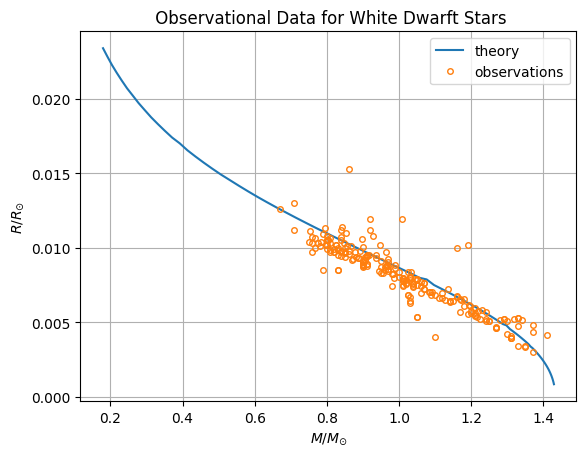

In [25]:

# The constants in the plot command convert our dimensionless units to the units of the solar mass and solar radius
plot(mass*0.71, radi*0.006, label="theory") 
plot(df.Mass, df.Rad, marker="o", linestyle="none", 
     fillstyle="none", markersize=4, label="observations")
grid(true)
xlabel(L"$M/M_{\odot}$")
ylabel(L"$R/R_{\odot}$")
title(" Observational Data for White Dwarft Stars")
legend();